# Detecção de sinais modulados por PSK por um canal AWGN através de Machine Learning

## Objetivos:
1) Encontrar os parâmetros necessários para que o algoritmo se aproxima o máximo possível da probabilidade de erro mínima possível teoricamente.

2) Descrever e classificar os hiperparâmetros dos algoritmos de classificação.

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import StandardScaler

from commpy.channels import SISOFlatChannel

from files_01_detection.qam_crazy import crazy_channel_propagate
from files_01_detection.psk_awgn import generate_symbols
from files_01_detection.psk_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix
 
%matplotlib inline

### Variáveis

In [65]:
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = 8      # QAM modulation
total_num_symbols  = 30000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.8 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [66]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(M, SNR_dB)
print("Theoretical symbol error probability (SER) =", 100.0*Pe, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 0.2339450237094587 % for SNR = 15 dB


### Generate PSK symbols and transmit them over the channel

In [67]:
# Generate the QAM symbols
symbs, indices = generate_symbols(total_num_symbols, M)

In [68]:
if channel_type == 'awgn':
    channel = SISOFlatChannel(None, (1 + 0j, 0j))
    channel.set_SNR_dB(SNR_dB, float(code_rate), Es)
    channel_output = channel.propagate(symbs)
elif channel_type == 'crazy':
    channel_output = crazy_channel_propagate(symbs, SNR_dB) 
else:
    raise ValueError(f'Channel type {channel_type} not found')

In [69]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
def plot_symbols():
    custom_cmap = cm.get_cmap('tab20')
    num_classes = M
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5

    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(X_train[selected_indices, 0], X_train[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(symbs), np.imag(symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)

    plt.show()  

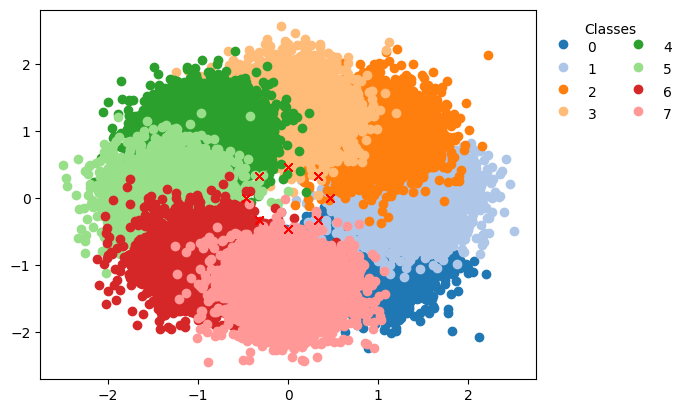

In [71]:
plot_symbols()

## KNN (Classificação dos vizinhos mais próximos)

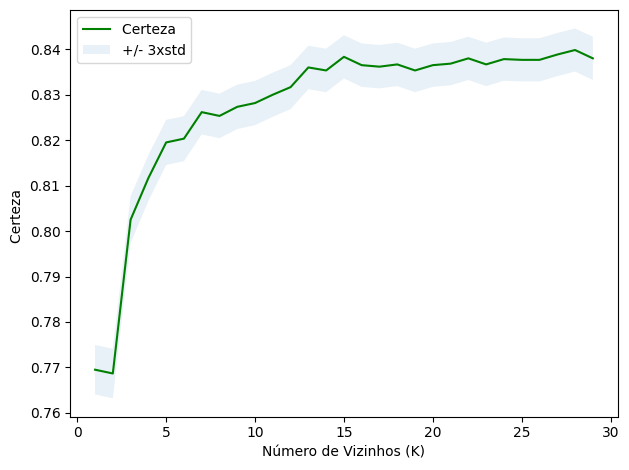

A melhor aproximação foi  0.8398333333333333 com k= 28
Utilizando o pesos de forma uniform foi obtido uma pontuação de 0.8398333333333333
Utilizando o pesos de forma distance foi obtido uma pontuação de 0.832


In [72]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Certeza ', '+/- 3xstd'))
plt.ylabel('Certeza ')
plt.xlabel('Número de Vizinhos (K)')
plt.tight_layout()
plt.show()

print( "A melhor aproximação foi ", mean_acc.max(), "com k=", mean_acc.argmax()+1)

for w in ['uniform','distance']:
    neigh = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1, weights=w).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    print(f'Utilizando o pesos de forma {w} foi obtido uma pontuação de {accuracy_score(y_test, yhat)}') 

## Train the classifier

In [73]:
classifier = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1, weights='uniform', algorithm='auto', 
                                   leaf_size=30, p=2, metric='minkowski', 
                                   metric_params=None, n_jobs=None)

classifier.fit(X_train, y_train) #train the classifier based on the training set

KNeighborsClassifier(n_neighbors=28)

### Plot decision regions for training set and confusion matrix for test set

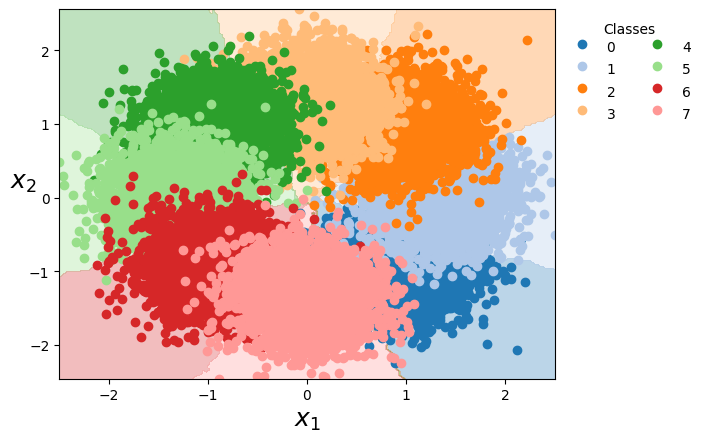

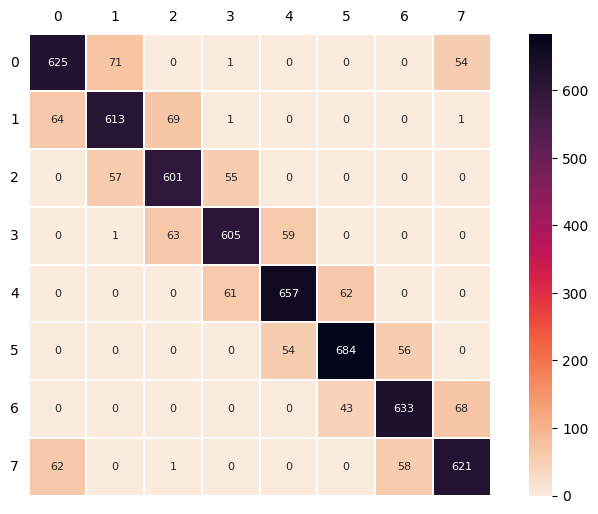

In [74]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

## Calculate the misclassification error

In [75]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for AWGN channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 16.02%
Theoretical SER for AWGN channel:	 0.23%


### Naive Bayes

Faz uso do teorema de Bayes para determinar P(Y|x)
Para tal descreve P(x|y) como uma gaussiana e adequa seus parâmetros fazendo uso da máxima verossimilhança

## Train the classifier

In [76]:
classifier = GaussianNB()

classifier.fit(X_train, y_train) #train the classifier based on the training set

GaussianNB()

### Plot decision regions for training set and confusion matrix for test set

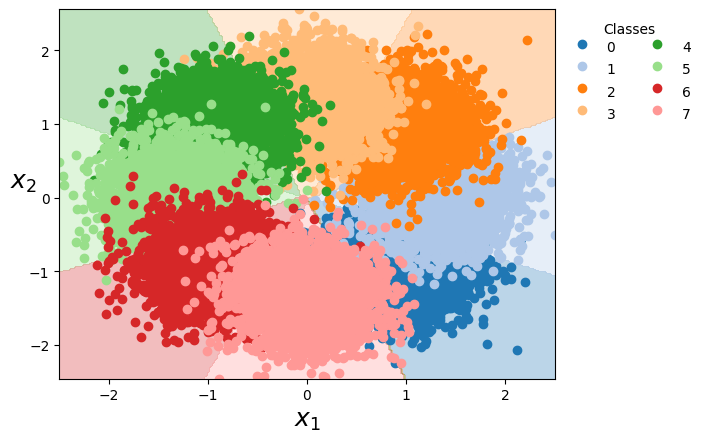

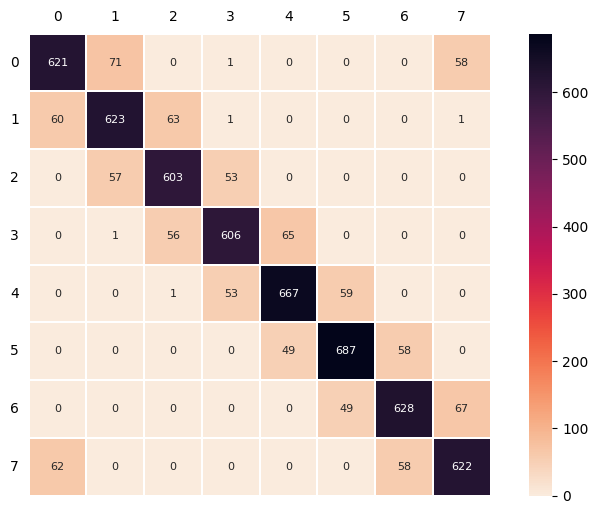

In [77]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

## Calculate the misclassification error

In [78]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for AWGN channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 15.72%
Theoretical SER for AWGN channel:	 0.23%


### Support Vector Machine (SVM)

Constroi um hiperplano que divide os conjuntos de dados

### Parâmetros importantes:

#### C -> Ajusta o tamanho da margem entre o hiperplano e os dados
#### Gamma -> Ajuste do hiperplano ao conjunto de dados
#### Kernel -> construção do hiperplano a partir da forma dos dados (linear ou curva)

In [79]:
params = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf','linear']}
clf = GridSearchCV(estimator=SVC(), param_grid=params, cv=5, n_jobs=5, verbose=1)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


## Train the classifier

In [80]:
classifier = SVC(C=clf.best_params_['C'], kernel=clf.best_params_['kernel'], gamma=clf.best_params_['gamma'], coef0=0.0, shrinking=True, 
                  probability=False, tol=0.001, cache_size=800, class_weight=None, 
                  verbose=False, max_iter=-1, decision_function_shape='ovr', 
                  break_ties=False, random_state=None)

classifier.fit(X_train, y_train)

SVC(C=100, degree=2, gamma=0.001, kernel='poly')

### Plot decision regions for training set and confusion matrix for test set

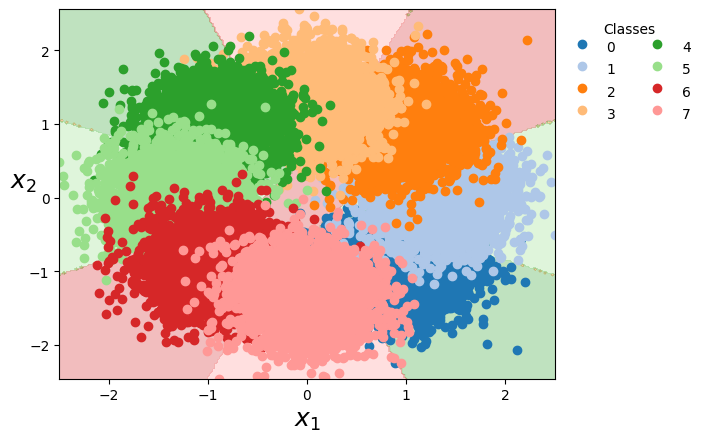

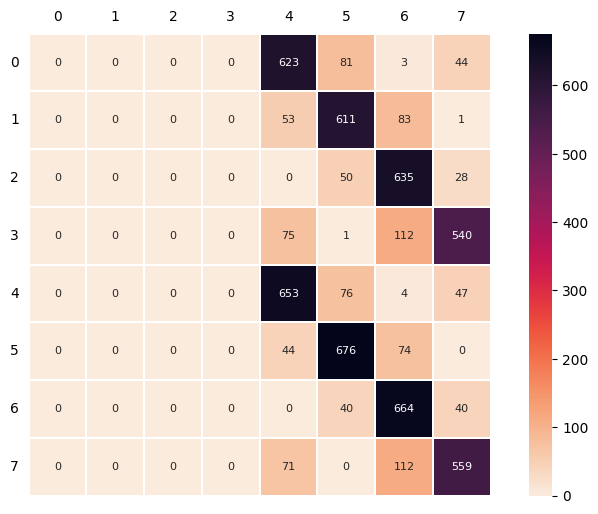

In [81]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

## Calculate the misclassification error

In [82]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for AWGN channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 57.47%
Theoretical SER for AWGN channel:	 0.23%


### Neural Net

## Train the classifier

In [37]:
classifier = MLPClassifier(alpha=0.1, max_iter=500, hidden_layer_sizes=(100,), 
                            activation='relu', solver='adam', batch_size='auto', 
                            learning_rate='constant', learning_rate_init=0.001, power_t=0.5,  
                            shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                            warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                            early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
                            beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

classifier.fit(X_train, y_train) #train the classifier based on the training set

SVC(C=100, gamma=0.001)

### Plot decision regions for training set and confusion matrix for test set

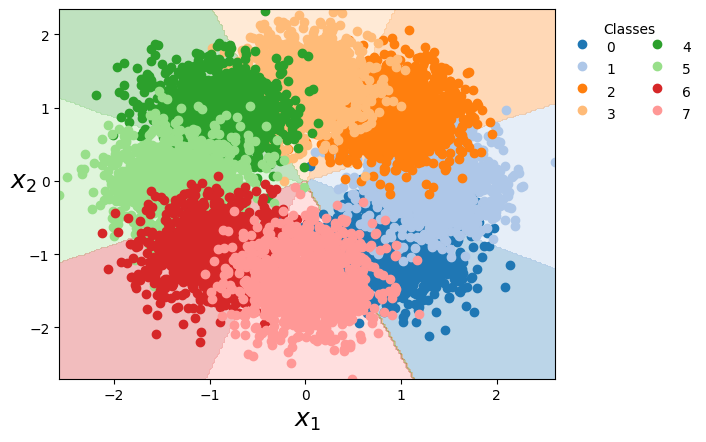

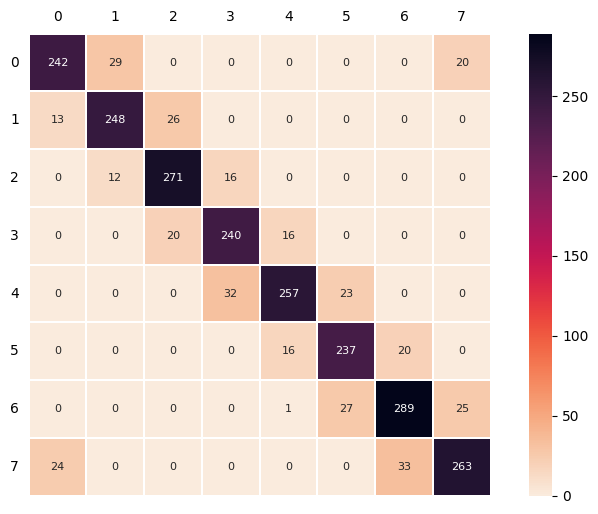

In [38]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

## Calculate the misclassification error

In [39]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for AWGN channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 14.71%
Theoretical SER for AWGN channel:	 0.23%
